In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!unzip -d /content/NASA_Soil_Moisture_India_Dataset/ /content/archive.zip
# !zipinfo /content/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/NASA_Soil_Moisture_India_Dataset/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed/Moderate_moisture/_0_1003.jpeg  
  inflating: /content/NASA_Soil_Moisture_India_Dataset/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed/Moderate_moisture/_0_1004.jpeg  
  inflating: /content/NASA_Soil_Moisture_India_Dataset/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed/Moderate_moisture/_0_1009.jpeg  
  inflating: /content/NASA_Soil_Moisture_India_Dataset/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed/Moderate_moisture/_0_1012.jpeg  
  inflating: /content/NASA_Soil_Moisture_India_Dataset/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed/Moderate_moisture/_0_1014.jpeg  
  inflating: /content/NASA_Soil_Moisture_India_Dataset/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed/Moderate_m

#### Install Dependencies

In [3]:
%pip install matplotlib numpy pandas keras scikit-learn opencv-python tensorflow pillow seaborn

#### Module Imports

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from PIL import Image
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

#### GPU Availability

In [5]:
print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

Number of GPUs Available:  1


True

#### Configuration

In [6]:
class Config:
    COLOR_MODE = 'rgb'
    ALLOWED_IMAGE_EXTENSIONS = ['png', 'jpg', 'jpeg']
    DATASET_PATH = '/content/NASA_Soil_Moisture_India_Dataset/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed'
    MOISTURE_LEVEL_CLASSES = os.listdir(DATASET_PATH)
    CLASSES = len(MOISTURE_LEVEL_CLASSES)
    PREPROCESS_DATASET = False
    USE_EARLY_STOPPING = False
    PRE_TRAINED_WEIGHTS = 'imagenet' # 'imagenet' or None
    MODEL_OF = 'Custom' # 'Custom' or 'Keras'

print(Config.MOISTURE_LEVEL_CLASSES)

['Highest_moisture', 'Moderate_moisture', 'Dry']


#### Utility Functions

In [7]:
def viewImage(image):
    plt.clf()

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#### Model Hyperparameters and Configurations

In [8]:
class HyperParameters:
    IMG_SIZE = 96
    IMG_CHANNELS = 3
    MODEL_OPTIMIZER = 'adam'
    EPOCHS = 200
    INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
    MODEL_LOSS_FUNCTION = 'sparse_categorical_crossentropy'
    TRAIN_BATCH_SIZE = 32
    TRAIN_DATA_SIZE = 0.7
    VAL_DATA_SIZE = 0.2
    TEST_DATA_SIZE = 0.1


## Dataset Preprocessing

In [9]:
if Config.PREPROCESS_DATASET:
    dataset_path = Config.DATASET_PATH
    os.makedirs(os.path.join(dataset_path, 'processed'), exist_ok=True)
    for image_class in os.listdir(dataset_path):
        os.makedirs(os.path.join(dataset_path, 'processed', image_class), exist_ok=True)
        for image in os.listdir(os.path.join(dataset_path, image_class)):
            image_path = os.path.join(dataset_path, image_class, image)
            processed_image_path = os.path.join(dataset_path, 'processed', image_class, image)
            try:
                img = cv2.imread(image_path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (HyperParameters.IMG_SIZE, HyperParameters.IMG_SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                with Image.open(image_path) as img_meta:
                    tip = img_meta.format.lower()
                    if tip not in Config.ALLOWED_IMAGE_EXTENSIONS:
                        print('Image not in ext list {}'.format(image_path))
                        os.remove(image_path)
                    else:
                        cv2.imwrite(processed_image_path, img)
            except Exception as e:
                print('Issue with image {}'.format(image_path))
                # os.remove(image_path)
    Config.DATASET_PATH = os.path.join(dataset_path, 'processed')

## Lazy Loading Dataset

In [10]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    f"{Config.DATASET_PATH}",
    image_size=(HyperParameters.IMG_SIZE, HyperParameters.IMG_SIZE),
    color_mode=Config.COLOR_MODE,
)
data = data.map(lambda x, y: (x / 255, y))
data_iterator = data.as_numpy_iterator()

Found 15002 files belonging to 3 classes.


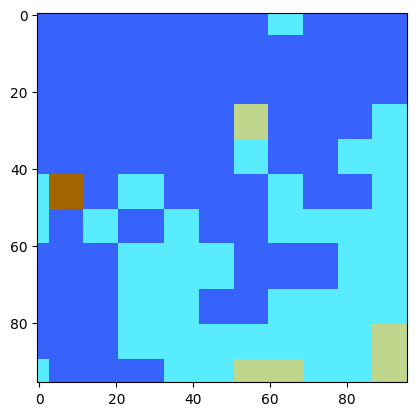

In [11]:
viewImage(data_iterator.next()[0][0])

## Spliting Dataset

In [12]:
train_size = int(len(data) * HyperParameters.TRAIN_DATA_SIZE)
val_size = int(len(data) * HyperParameters.VAL_DATA_SIZE)
test_size = int(len(data) * HyperParameters.TEST_DATA_SIZE)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# ResNet50 Model

## Structure

There are consecutive blocks of layers that resemble the following structure:

|Block (image, f1, f2, f3)|
|:---|
|Conv2D(filter: 1x1, #filters: &lt;f1&gt;, stride: (1,1), padding: No padding)|
|Normalize along channels & ReLU|
|Conv2D(filter: 3x3, #filters: &lt;f2&gt;, stride: (1,1), padding: Same Output and Input image dimensions)|
|Normalize along channels & ReLU|
|Conv2D(filter: 1x1, #filters: &lt;f3&gt;, stride: (1,1), padding: No padding)|
|Normalize along channels|
|if &lt;image&gt; dimensions != output dimensions|
|Conv2D(filter: 1x1, filters: &lt;f3&gt;, stride: (1,1), padding: No padding)|
|Add the outputs & ReLU|

### Filters

|Block Number|f1|f2|f3|
|:---:|:---:|:---:|:---:|
|1|64|64|256|
|2|128|128|512|
|3|256|256|1024|
|4|512|512|2048|

### Block Repetitions

(Block 1) x 3 \
(Block 2) x 4 \
(Block 3) x 6 \
(Block 4) x 3


### Identity Block

Used for same consecutive blocks
Since, The input image added as part of "skip connection" feature is same size of the output
Ex. second and third instances of Block 1 are resembled by Identity Block

In [13]:
def identity_block(X, f, filters, stage, block):
    """
    @param X: input of shape (m, height, width, channel)
    @param f: shape of the middle CONV's window for the main path
    @param filters: python list of integers, defining the number of filters in the CONV layers of the main path
    @param stage: integer, used to name the layers, depending on their position in the network
    @param block: string/character, used to name the layers, depending on their position in the network

    Returns:
    X: output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters
    X_shortcut = X

    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)


    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

### Convolutional Block

Used for every first instance of the blocks
Since, The input image added as part of "skip connection" feature is from last block of previous block and of different size than the output
Ex. first instance of Block 1 are resembled by Convolutional Block

In [14]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters
    X_shortcut = X


    # First layer
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s), padding = 'same', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)


    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# Architecture

|ResNet50|
|:---:|
|**Initial Processing**|
|Conv2D(filter: 7x7, #filters: 64, stride: (2,2), padding: No padding)|
|Normalize along channels & ReLU|
|MaxPool2D(filter: 3x3, strides: (2,2))|
|**Block 1**|
|ConvolutionalBlock(Block 1) x 1|
|IdentityBlock(Block 1) x 2|
|**Block 2**|
|ConvolutionalBlock(Block 2) x 1|
|IdentityBlock(Block 2) x 3|
|**Block 3**|
|ConvolutionalBlock(Block 3) x 1|
|IdentityBlock(Block 3) x 5|
|**Block 4**|
|ConvolutionalBlock(Block 4) x 1|
|IdentityBlock(Block 4) x 2|
|**Fully connected Layer**|
|AveragePool2D(filter: 2x2, stride: (1,1), kernel_initializer: glorot_uniform(seed: 0))|
|Flatten, Dense(<classes>), Softmax|

In [15]:
def CustomResNet50(input_shape=(96, 96, 3), classes=3):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D((2,2), name="avg_pool")(X)

    X = Flatten()(X)
    X = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [16]:
def KerasResNet50(include_top=True, weights='imagenet', input_shape=None, classes=1000):
    base_model = tf.keras.applications.ResNet50(weights=weights, include_top=include_top, input_shape=input_shape, classes=classes)
    if weights == 'imagenet':
        for layer in base_model.layers:
            layer.trainable = False
    X = base_model.output
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(X)
    X = tf.keras.layers.Dense(Config.CLASSES, activation='softmax')(X)
    return tf.keras.models.Model(inputs=base_model.input, outputs=X)

In [17]:
kerasModel = KerasResNet50(weights=None, include_top=False, input_shape=HyperParameters.INPUT_SHAPE)
fineTunedModel = KerasResNet50(weights='imagenet', include_top=False, input_shape=HyperParameters.INPUT_SHAPE, classes=Config.CLASSES)
customModel = CustomResNet50(input_shape = HyperParameters.INPUT_SHAPE, classes = Config.CLASSES)

kerasModel.compile(optimizer=HyperParameters.MODEL_OPTIMIZER, loss=HyperParameters.MODEL_LOSS_FUNCTION, metrics=['accuracy'])
fineTunedModel.compile(optimizer=HyperParameters.MODEL_OPTIMIZER, loss=HyperParameters.MODEL_LOSS_FUNCTION, metrics=['accuracy'])
customModel.compile(optimizer=HyperParameters.MODEL_OPTIMIZER, loss=HyperParameters.MODEL_LOSS_FUNCTION, metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
models = {
    # "CUSTOM":customModel,
    "KERAS": kerasModel,
    # "FINETUNED": fineTunedModel
}
for name, model in models.items():
    print(name)
    print(model.summary())

KERAS


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 102, 102, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 48, 48, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 48, 48, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 48, 48, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 50, 50, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 24, 24, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 24, 24, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 24, 24, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 24, 24, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 24, 24, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 24, 24, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 24, 24, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 24, 24, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 24, 24, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 25,635,843 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [19]:
history = {}

for name, model in models.items():
    print(f"Training {name} ResNet50 model")
    if Config.USE_EARLY_STOPPING:
        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )

        history[name] = model.fit(
            train,
            epochs = HyperParameters.EPOCHS,
            batch_size = HyperParameters.TRAIN_BATCH_SIZE,
            validation_data=val,
            callbacks=[early_stopping],
        )
    else:
        history[name] = model.fit(
            train,
            epochs = HyperParameters.EPOCHS,
            batch_size = HyperParameters.TRAIN_BATCH_SIZE,
            validation_data=val,
        )

Training KERAS ResNet50 model
Epoch 1/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 101s 130ms/step - accuracy: 0.9152 - loss: 6.5196 - val_accuracy: 0.6546 - val_loss: 2.2908
Epoch 2/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 50s 116ms/step - accuracy: 0.9900 - loss: 0.1715 - val_accuracy: 0.9943 - val_loss: 0.0365
Epoch 3/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - accuracy: 0.9909 - loss: 0.0351 - val_accuracy: 0.9852 - val_loss: 0.0513
Epoch 4/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - accuracy: 0.9912 - loss: 0.0394 - val_accuracy: 0.9755 - val_loss: 0.1173
Epoch 5/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 49s 145ms/step - accuracy: 0.9838 - loss: 0.1841 - val_accuracy: 0.9896 - val_loss: 1.2075
Epoch 6/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - accuracy: 0.9892 - loss: 0.0515 - val_accuracy: 0.9822 - val_loss: 0.4202
Epoch 7/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 48s 146ms/step - accuracy: 0.9904 - loss: 0.0430 - val_accuracy: 0.8861 - val_loss: 0.4026
Epoch 8/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 74s 

# TEST

In [20]:
for name, model in models.items():
    print("-"*30, name, sep="\n")
    preds = model.evaluate(test)
    print ("Loss = " + str(preds[0]))
    print ("Test Accuracy = " + str(preds[1]))

------------------------------
KERAS
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9983 - loss: 0.0038
Loss = 0.008043497800827026
Test Accuracy = 0.99660325050354


# Analysis

### Accuracy

<Figure size 640x480 with 0 Axes>

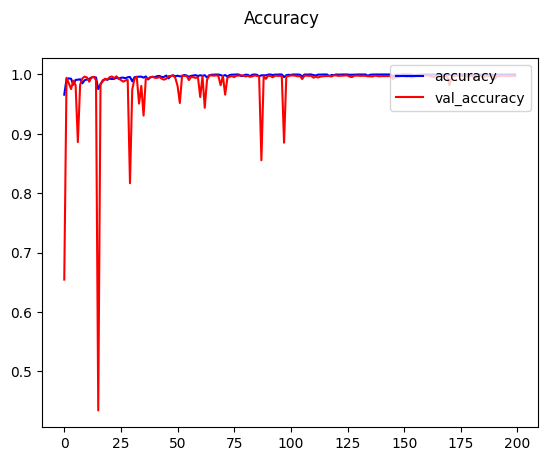

In [21]:
for name, hist in history.items():
    plt.clf()
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
    fig.suptitle('Accuracy')
    plt.legend(loc="upper right")
    plt.show()
    fig.savefig(f'/content/results/{name}_resnet50_accuracy.png')

### Loss

<Figure size 640x480 with 0 Axes>

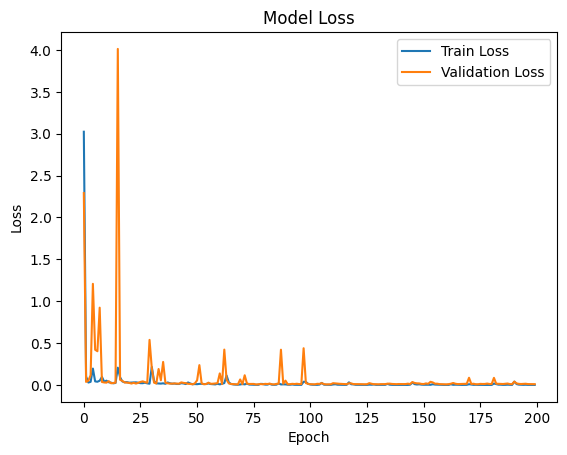

In [22]:
for name, hist in history.items():
    plt.clf()
    fig = plt.figure()
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    #plt.ylim(0, 0.2)  # Set y-axis range to [0, 1]
    plt.legend(loc='upper right')
    plt.show()
    fig.savefig(f'/content/results/{name}_resnet50_loss.png')

### Confusion Matrix

46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step
Class labels: {'Dry': 0, 'Moderate_moisture': 1, 'Highest_moisture': 2}


<Figure size 640x480 with 0 Axes>

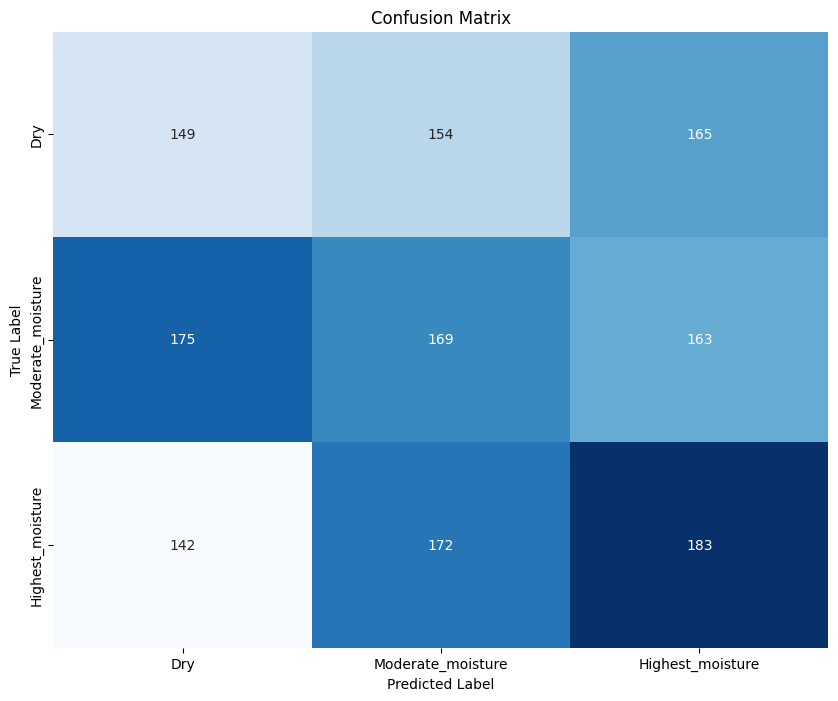

In [23]:
for name, model in models.items():
    y_true = np.concatenate([y for _, y in test], axis=0)
    y_pred = model.predict(test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)

    class_labels= {'Dry': 0, 'Moderate_moisture': 1, 'Highest_moisture': 2}
    print("Class labels:", class_labels)

    # 3. Plot the confusion matrix
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    fig.savefig(f'/content/results/{name}_resnet50_confusion_matrix.png')

### Classification Report on Validation Set

46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step
Class labels: {'Dry': 0, 'Moderate_moisture': 1, 'Highest_moisture': 2}


<Figure size 640x480 with 0 Axes>

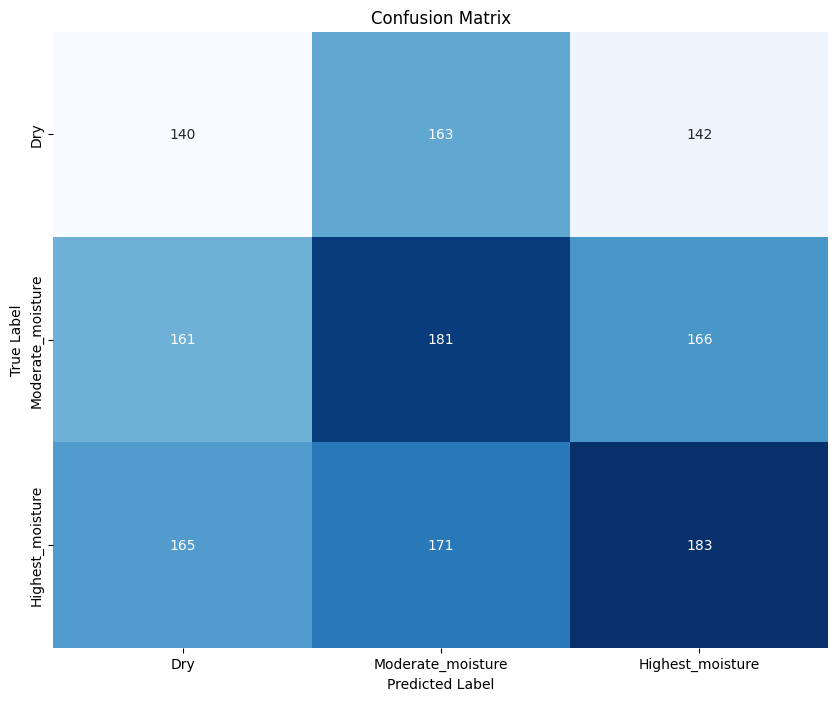

In [29]:
for name, model in models.items():
    y_true = np.concatenate([y for _, y in test], axis=0)
    y_pred = model.predict(test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)

    class_labels= {'Dry': 0, 'Moderate_moisture': 1, 'Highest_moisture': 2}
    print("Class labels:", class_labels)

    # 3. Plot the confusion matrix
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    fig.savefig(f'/content/results/{name}_resnet50_confusion_matrix.png')

In [30]:
for name, model in models.items():
    y_true = np.concatenate([y for _, y in test], axis=0)
    y_pred = model.predict(test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    report = classification_report(y_true, y_pred_classes, target_names=class_labels.keys())

    print(name, "Classification Report:", sep="\n")
    print(report)

46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step
KERAS
Classification Report:
                   precision    recall  f1-score   support

              Dry       0.30      0.30      0.30       454
Moderate_moisture       0.38      0.38      0.38       500
 Highest_moisture       0.36      0.36      0.36       518

         accuracy                           0.35      1472
        macro avg       0.35      0.35      0.35      1472
     weighted avg       0.35      0.35      0.35      1472



In [27]:
models['KERAS'].save('/content/results/keras_resnet50.keras')

In [28]:
for name, model in models.items():
    y_true = np.concatenate([y for _, y in val], axis=0)
    y_pred = model.predict(val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    report = classification_report(y_true, y_pred_classes, target_names=class_labels.keys())

    print(name, "Classification Report:", sep="\n")
    print(report)

93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step
KERAS
Classification Report:
                   precision    recall  f1-score   support

              Dry       0.35      0.35      0.35      1021
Moderate_moisture       0.32      0.32      0.32       956
 Highest_moisture       0.35      0.35      0.35       999

         accuracy                           0.34      2976
        macro avg       0.34      0.34      0.34      2976
     weighted avg       0.34      0.34      0.34      2976



# INFERENCE

In [32]:
img_paths = [
    '/content/NASA_Soil_Moisture_India_Dataset/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed/Highest_moisture/soil_moisture_india_and_sri_lanka_2015-04-08_class_5_patch_14.png',
    '/content/NASA_Soil_Moisture_India_Dataset/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed/Dry/_0_108.jpeg',
    '/content/NASA_Soil_Moisture_India_Dataset/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed/Moderate_moisture/_0_1004.jpeg',
]

for img_path in img_paths:
    img = image.load_img(img_path, target_size=(HyperParameters.IMG_SIZE, HyperParameters.IMG_SIZE))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0
    # x = preprocess_input(x)
    print('Input image shape:', x.shape)
    my_image = cv2.imread(img_path)
    # viewImage(my_image)
    inference = model.predict(x)
    print(inference)
    print(inference.shape)
    print(np.argmax(inference))

Input image shape: (1, 96, 96, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[3.2432932e-09 1.0000000e+00 8.4581231e-09]]
(1, 3)
1
Input image shape: (1, 96, 96, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[1.000000e+00 4.930919e-12 2.630236e-11]]
(1, 3)
0
Input image shape: (1, 96, 96, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[7.5016573e-07 1.7283661e-06 9.9999750e-01]]
(1, 3)
2
